## Collect
Step 1 of the Data Lifecycle

We remove the lines where the "Code du départemnt" is empty and it correspond to all the DOM-TOM department
We also remove the Code de la catégorie socio-professionnelle which is just a code without meaning and we keep it as a text that we will convert to dummies after

This is out first dataset from https://www.data.gouv.fr/datasets/repertoire-national-des-elus-1/?resource_id=2876a346-d50c-4911-934e-19ee07b0e503 

In [70]:
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os, requests, re, json, random, time

In [6]:
repertoire = pd.read_csv("elus-maires-mai.csv", delimiter=";")
repertoire.drop(columns=['Libellé de la collectivité à statut particulier', 'Code de la collectivité à statut particulier', 'Code de la catégorie socio-professionnelle'], inplace=True)
repertoire.dropna(subset=["Code du département"], inplace=True)
repertoire.head()

,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Nom de l'élu,Prénom de l'élu,Code sexe,Date de naissance,Libellé de la catégorie socio-professionnelle,Date de début du mandat,Date de début de la fonction
0,01,Ain,01001,L'Abergement-Clémenciat,BOULON,Daniel,M,04/03/1951,Ancien cadre,18/05/2020,26/05/2020
1,01,Ain,01002,L'Abergement-De-Varey,ORSET,Max,M,02/11/1947,"Ouvrier qualifié de la manutention, du magasin...",18/05/2020,27/05/2020
2,01,Ain,01004,Ambérieu-En-Bugey,FABRE,Daniel,M,07/09/1961,Ancien cadre,18/05/2020,28/05/2020
3,01,Ain,01005,Ambérieux-En-Dombes,FORNES,Christine,F,06/07/1962,Artisan,02/05/2021,07/05/2021
4,01,Ain,01006,Ambléon,BIONDA,Annie,F,28/11/1951,Ancien employé,18/05/2020,25/05/2020


In [7]:
repertoire["Libellé de la catégorie socio-professionnelle"] = repertoire["Libellé de la catégorie socio-professionnelle"].str.replace("(obsolète)", "")
repertoire["Libellé de la catégorie socio-professionnelle"].value_counts()

Libellé de la catégorie socio-professionnelle
Ancien cadre                                                                         5531
Agriculteur sur moyenne exploitation                                                 2858
Ancien employé                                                                       2215
Ancien agriculteur exploitant                                                        1941
Cadre administratif et commercial d'entreprise                                       1896
Cadre de la fonction publique                                                        1872
Ancienne profession intermédiaire                                                    1428
Ancien artisan, commerçant, chef d'entreprise                                        1400
Ingénieur et cadre technique d'entreprise                                            1243
Profession libérale                                                                  1200
Professeur, profession scientifique                   

Let's scrap all the information from the API of the government about the towns to knows their size in km2 and in population. We also get the type of city it is (metropolitan or rural) and we get the Zip code of the cities

Our second dataset is :
https://geo.api.gouv.fr/decoupage-administratif/communes

In [27]:
def ajouter_infos_communes(df, code_colonne='Code de la commune'):
    """
    Retrieves API information for each municipality and adds it to the DataFrame.
    
    df: Existing DataFrame with a column containing the INSEE codes for municipalities.
    column_code: Name of the column containing the INSEE codes.
    """
    infos = []

    for code in df[code_colonne].dropna().unique():
        url = f"https://geo.api.gouv.fr/communes/{code}?&fields=code,nom,population,surface,zone,codesPostaux"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            infos.append({
                "code": data.get("code"),
                "nom": data.get("nom"),
                "codesPostaux": data.get("codesPostaux"),
                "codeEpci": data.get("codeEpci"),
                "codeDepartement": data.get("codeDepartement"),
                "codeRegion": data.get("codeRegion"),
                "population": data.get("population"),
                "zone": data.get("zone")
            })
        else:
            print(f"Erreur pour le code {code} : {response.status_code}")

    df_infos = pd.DataFrame(infos)

    df = df.merge(df_infos, left_on=code_colonne, right_on="code", how="left")
    
    return df

repertoire = ajouter_infos_communes(repertoire, code_colonne="Code de la commune")
repertoire.to_csv("repertoire_with_codes_population.csv", index=False, encoding="utf-8")

Erreur pour le code 01330 : 404
Erreur pour le code 14011 : 404
Erreur pour le code 18131 : 404
Erreur pour le code 19223 : 404
Erreur pour le code 19230 : 404
Erreur pour le code 22027 : 404
Erreur pour le code 22043 : 404
Erreur pour le code 22309 : 404
Erreur pour le code 49069 : 404
Erreur pour le code 63330 : 404
Erreur pour le code 69152 : 404
Erreur pour le code 69159 : 404
Erreur pour le code 72287 : 404
Erreur pour le code 72298 : 404
Erreur pour le code 93059 : 404
Erreur pour le code 95282 : 404


We save because we don't want to lose an hour of execution

In [26]:
repertoire.to_csv("repertoire_with_codes_population.csv", index=False, encoding="utf-8")

Since the dataset is very big and we many features are not available for smaller cities, we decide to keep only the ones with more than 10000 people

Count of the towns's populations > 10000 : 1015


/var/folders/_f/0ygxmxlx0bnbs9bc_k31wlmr0000gn/T/ipykernel_3324/1630297357.py:1: DtypeWarning: Columns (0,2,11) have mixed types. Specify dtype option on import or set low_memory=False.
  repertoire = pd.read_csv("repertoire_with_codes_population.csv")


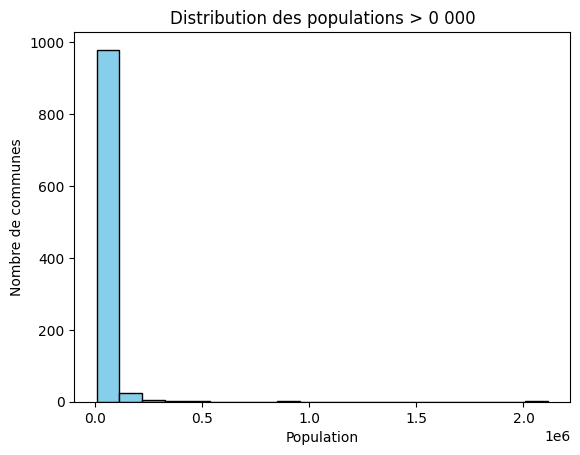

,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Nom de l'élu,Prénom de l'élu,Code sexe,Date de naissance,Libellé de la catégorie socio-professionnelle,Date de début du mandat,Date de début de la fonction,code,nom,codesPostaux,codeEpci,codeDepartement,codeRegion,population,zone
2,01,Ain,01004,Ambérieu-En-Bugey,FABRE,Daniel,M,07/09/1961,Ancien cadre,18/05/2020,28/05/2020,01004,Ambérieu-en-Bugey,['01500'],NaN,NaN,NaN,15554.0,metro
28,01,Ain,01033,Valserhône,PETIT,Régis,M,06/04/1956,Ancienne profession intermédiaire,18/05/2020,25/05/2020,01033,Valserhône,['01200'],NaN,NaN,NaN,16162.0,metro
46,01,Ain,01053,Bourg-En-Bresse,DEBAT,Jean-François,M,24/01/1966,Cadre de la fonction publique,28/06/2020,28/06/2020,01053,Bourg-en-Bresse,['01000'],NaN,NaN,NaN,42065.0,metro
122,01,Ain,01143,Divonne-Les-Bains,SCATTOLIN,Vincent,M,27/01/1979,Personne diverse sans activité professionnelle...,18/05/2020,26/05/2020,01143,Divonne-les-Bains,['01220'],NaN,NaN,NaN,10300.0,metro
137,01,Ain,01160,Ferney-Voltaire,RAPHOZ,Daniel,M,06/12/1955,Ancien cadre,28/06/2020,03/07/2020,01160,Ferney-Voltaire,['01210'],NaN,NaN,NaN,11530.0,metro


In [55]:
repertoire = pd.read_csv("repertoire_with_codes_population.csv")
repertoire_shorter = repertoire[repertoire["population"] > 10000]
somme_population = repertoire_shorter["population"].count()
print("Count of the towns's populations >", 10000, ":", somme_population)

plt.hist(repertoire_shorter["population"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution des populations > 0 000")
plt.xlabel("Population")
plt.ylabel("Nombre de communes")
plt.show()

repertoire_shorter.head()

We get to the third dataset which is the most important one with the political parties and the cities around it: https://politique.pappers.fr/commune/{code_commune}

In [ ]:
import cloudscraper
from bs4 import BeautifulSoup

def get_commune_info_cloudscraper(code_commune):
    url = f"https://politique.pappers.fr/commune/{code_commune}"

    scraper = cloudscraper.create_scraper(
        browser={
            'browser': 'chrome',
            'platform': 'windows',
            'mobile': False
        }
    )

    html = scraper.get(url).text
    soup = BeautifulSoup(html, "html.parser")

    etiquette = None
    voisins = []

    for div in soup.select("div.metadata"):
        label = div.select_one("span.identifier")
        text = div.select_one("span.metadata-text")
        
        if not label or not text:
            continue

        if "Etiquette (parti) politique lors de l'élection" in label.text:
            etiquette = text.text.strip()

        if "Communes avoisinantes" in label.text:
            links = text.select("a")
            for a in links[:3]:
                href = a.get("href")
                code = href.split("-")[-1]
                voisins.append(code)

    return [
        etiquette,
        voisins
    ]

In [56]:
from tqdm import tqdm

def scrape_all_communes(df):
    """
    Ajoute 2 colonnes :
    - etiquette_politique
    - communes_voisines (liste)
    
    Utilise CloudScraper pour contourner les protections.
    """
    etiquettes = []
    voisins_list = []

    for code in tqdm(df["Code de la commune"], desc="Scraping communes"):
        if pd.isna(code):
            etiquettes.append(None)
            voisins_list.append([])
            continue

        etiq, voisins = get_commune_info_cloudscraper(code)
        etiquettes.append(etiq)
        voisins_list.append(voisins)

    df["etiquette_politique"] = etiquettes
    df["communes_voisines"] = voisins_list

    return df

In [ ]:
repertoire_neighbour_politic = scrape_all_communes(repertoire_shorter)
repertoire_neighbour_politic.to_csv("repertoire_neighbour_politic.csv", index=False, encoding="utf-8")
repertoire = repertoire_neighbour_politic.copy()

Scraping communes: 100%|██████████| 1015/1015 [07:35<00:00,  2.23it/s]
/var/folders/_f/0ygxmxlx0bnbs9bc_k31wlmr0000gn/T/ipykernel_1224/33917282.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["etiquette_politique"] = etiquettes
/var/folders/_f/0ygxmxlx0bnbs9bc_k31wlmr0000gn/T/ipykernel_1224/33917282.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["communes_voisines"] = voisins_list


Let's take a look at the different paries we have, we will filter them afterwards

In [32]:
repertoire = pd.read_csv("repertoire_neighbour_politic.csv")
repertoire['etiquette_politique'].value_counts()

etiquette_politique
Divers droite                               249
Divers gauche                               152
Divers Centre                                97
Les Républicains                             84
Union de la gauche                           56
Divers                                       46
Parti socialiste                             37
Union de la droite                           28
Parti Communiste Francais                    19
Union des Démocrates et des Indépendants     14
Union du Centre                              10
Rassemblement National                        8
Europe Écologie Les Verts                     4
Écologiste                                    4
Liste régionaliste                            3
LREM                                          3
MoDem                                         2
Extrême droite                                1
Name: count, dtype: int64

Here is our last but not least dataset with major data from INSEE, we get many data about emploi_actifs,emploi_retraites,socio_pro,pauvrete_ensemble,natalite,mortalite,diplome_bac,diplome_bac5_plus in pourcentage

The fourth dataset is from https://www.insee.fr/fr/statistiques/2011101?geo=COM{code}

In [44]:
# Helper utilities Insee Stats, process all
# --------------------------
def _make_scraper():
    return cloudscraper.create_scraper(
        browser={
            'browser': 'chrome',
            'platform': 'windows',
            'mobile': False
        }
    )

def _norm_text(s):
    if s is None:
        return ""
    return re.sub(r"\s+", " ", s.strip()).lower()

def _parse_number_to_float(s):
    """
    Nettoie une chaîne comme "66,2", "1 787", "–0,4", "100,0" et retourne un float.
    Retourne None si impossible à parser.
    """
    if s is None:
        return None
    s = str(s).strip()
    # remplace les tirets spéciaux par - et supprime espaces non-breaking
    s = s.replace("\u2013", "-").replace("\u2014", "-")  # – — → -
    s = s.replace("\xa0", " ").replace("\u202f", " ")
    s = s.replace(" ", "")  # supprime tous les espaces restants dans les nombres groupés
    # remplace la virgule décimale par un point
    s = s.replace(",", ".")
    # supprime % ou ‰ si présents (on garde note: taux natalité/mortalité en ‰)
    s = s.replace("%", "").replace("‰", "")
    # parfois tableau contient des caractères non numériques -> regex
    m = re.search(r"(-?\d+(\.\d+)?)", s)
    if not m:
        return None
    try:
        return float(m.group(1))
    except:
        return None

# --------------------------
# Core scrapper for one commune
# --------------------------
def get_insee_stats(code_commune, scraper=None, verbose=False):
    """
    Récupère plusieurs indicateurs depuis la page INSEE pour la commune.
    Input:
      - code_commune : str (ex "93032") or int
      - scraper : optional cloudscraper instance (créé si None)
    Retour:
      dict avec clefs:
        emploi_actifs, emploi_retraites, socio_pro (dict),
        pauvrete_ensemble, natalite, mortalite,
        diplome_bac, diplome_bac5_plus
      les valeurs sont des floats ou None.
    """
    if scraper is None:
        scraper = _make_scraper()

    code = str(code_commune).zfill(5)
    url = f"https://www.insee.fr/fr/statistiques/2011101?geo=COM-{code}"

    # valeurs par défaut
    result = {
        "code_commune": code,
        "emploi_actifs": None,
        "emploi_retraites": None,
        "socio_pro": {},          # dict label -> percent
        "pauvrete_ensemble": None,
        "natalite": None,
        "mortalite": None,
        "diplome_bac": None,
        "diplome_bac5_plus": None
    }

    try:
        html = scraper.get(url, timeout=30).text
    except Exception as e:
        if verbose:
            print(f"[ERROR] réseau pour {code}: {e}")
        return result

    soup = BeautifulSoup(html, "html.parser")

    # ---------- EMP G1 : Actifs ayant un emploi & Retraités ----------
    try:
        table_emp_g1 = soup.find("table", id="produit-tableau-EMP_G1")
        if table_emp_g1:
            # parcourir les tr pour trouver les labels demandés
            for tr in table_emp_g1.select("tbody tr"):
                th = tr.find("th")
                td = tr.find("td")
                if not th or not td:
                    continue
                label = _norm_text(th.get_text())
                value = _parse_number_to_float(td.get_text())
                if "actifs ayant un emploi" in label:
                    result["emploi_actifs"] = value
                elif "retrait" in label:  # "Retraités"
                    result["emploi_retraites"] = value
    except Exception as e:
        if verbose:
            print(f"[WARN] EMP_G1 parse failed for {code}: {e}")

    # ---------- EMP T7 : Emplois par groupe socioprofessionnel (prendre %) ----------
    try:
        table_emp_t7 = soup.find("table", id="produit-tableau-EMP_T7")
        if table_emp_t7:
            # Les colonnes peuvent être [Groupe, Nombre, %] ; on lit la dernière colonne de chaque row
            for tr in table_emp_t7.select("tbody tr"):
                th = tr.find("th")
                tds = tr.select("td")
                if not th or not tds:
                    continue
                label = _norm_text(th.get_text())
                # trouver la cellule % : soit la dernière td visible, soit la dernière td
                pct = None
                # prefer last td
                pct = _parse_number_to_float(tds[-1].get_text())
                # exclure la ligne 'Ensemble' si on veut seulement catégories; on inclut tout sauf "ensemble" key
                if "ensemble" in label:
                    continue
                # ajouter au dict si label non vide
                if label:
                    # garder le libellé tel quel (sans normalization) pour lisibilité
                    raw_label = th.get_text().strip()
                    result["socio_pro"][raw_label] = pct
    except Exception as e:
        if verbose:
            print(f"[WARN] EMP_T7 parse failed for {code}: {e}")

    # ---------- REV G1 : Taux de pauvreté - rechercher la ligne "Ensemble" ----------
    try:
        table_rev_g1 = soup.find("table", id="produit-tableau-REV_G1")
        if table_rev_g1:
            for tr in table_rev_g1.select("tbody tr"):
                th = tr.find("th")
                td = tr.find("td")
                if not th or not td:
                    continue
                label = _norm_text(th.get_text())
                if "ensemble" in label:
                    result["pauvrete_ensemble"] = _parse_number_to_float(td.get_text())
                    break
    except Exception as e:
        if verbose:
            print(f"[WARN] REV_G1 parse failed for {code}: {e}")

    # ---------- POP T2M : taux de natalité & mortalité -> prendre la dernière colonne ----------
    try:
        table_pop_t2m = soup.find("table", id="produit-tableau-POP_T2M")
        if table_pop_t2m:
            # On veut la dernière colonne (la plus récente) -> prendre le dernier td de la ligne correspondante
            for tr in table_pop_t2m.select("tbody tr"):
                th = tr.find("th")
                if not th:
                    continue
                label = _norm_text(th.get_text())
                tds = tr.select("td")
                if not tds:
                    continue
                last_td_text = tds[-1].get_text()
                val = _parse_number_to_float(last_td_text)
                if "taux de natalit" in label:  # 'Taux de natalité  (‰)'
                    result["natalite"] = val
                elif "taux de mortalit" in label:
                    result["mortalite"] = val
    except Exception as e:
        if verbose:
            print(f"[WARN] POP_T2M parse failed for {code}: {e}")

    # ---------- FOR T2 : diplômes -> baccalauréat & bac+5+ ----------
    try:
        table_for_t2 = soup.find("table", id="produit-tableau-FOR_T2")
        if table_for_t2:
            for tr in table_for_t2.select("tbody tr"):
                th = tr.find("th") or tr.find("td", recursive=False)  # parfois format différent
                tds = tr.select("td")
                if not th:
                    continue
                label = _norm_text(th.get_text())
                # chercher la cellule 'Ensemble' qui est normalement le premier td (index 0)
                # on choisit tds[0] si présent et utile
                ensemble_val = None
                if len(tds) >= 1:
                    ensemble_val = _parse_number_to_float(tds[0].get_text())
                # matcher les deux labels demandés
                if "baccalauréat" in label and "brevet professionnel" in label or "baccalauréat" in label and "équivalent" in label:
                    # correspond à "Baccalauréat, brevet professionnel ou équivalent"
                    result["diplome_bac"] = ensemble_val
                elif "bac + 5" in label or "niveau bac + 5" in label or "bac +5" in label or "diplôme de l'enseignement supérieur de niveau bac + 5" in label:
                    result["diplome_bac5_plus"] = ensemble_val
                else:
                    # fallback - sometimes label differs; explicit checks:
                    if "baccalauréat" in label and "professionnel" not in label:
                        # rare fallback
                        if result["diplome_bac"] is None:
                            result["diplome_bac"] = ensemble_val
    except Exception as e:
        if verbose:
            print(f"[WARN] FOR_T2 parse failed for {code}: {e}")

    return result

# --------------------------
# Loop over DataFrame and save results
# --------------------------
def process_all_communes(in_csv="repertoire_avec_codes_population.csv",
                         out_csv="repertoire_insee_enriched.csv",
                         code_col="Code de la commune",
                         delay_min=0.8,
                         delay_max=1.8,
                         verbose=False):
    """
    Lit in_csv (CSV), prend la colonne code_col, scrape INSEE pour chaque ligne,
    ajoute une colonne 'insee_stats' (JSON string) et sauvegarde out_csv.
    - delay_min / delay_max : délai aléatoire entre requêtes (pour être poli)
    """
    df = pd.read_csv(in_csv, dtype=str)
    # créer scraper unique (réutilisable)
    scraper = _make_scraper()

    # initialiser colonne result vide
    insee_stats_list = []

    # itérer sur chaque code (lignes dans l'ordre)
    for code in tqdm(df[code_col].fillna("").astype(str), desc="Scraping INSEE"):
        if code == "" or code.lower() == "nan":
            insee_stats_list.append(None)
            continue

        try:
            stats = get_insee_stats(code, scraper=scraper, verbose=verbose)
        except Exception as e:
            if verbose:
                print(f"[ERROR] unexpected error for {code}: {e}")
            stats = {
                "code_commune": str(code).zfill(5),
                "emploi_actifs": None,
                "emploi_retraites": None,
                "socio_pro": {},
                "pauvrete_ensemble": None,
                "natalite": None,
                "mortalite": None,
                "diplome_bac": None,
                "diplome_bac5_plus": None
            }

        # store as JSON string to keep the dataframe serialisable
        insee_stats_list.append(json.dumps(stats, ensure_ascii=False))

        # polite delay
        time.sleep(random.uniform(delay_min, delay_max))

    df["insee_stats"] = insee_stats_list

    # Optionnel : décompresser certaines valeurs en colonnes séparées pour faciliter l'analyse
    # Exemple : emploi_actifs, emploi_retraites, pauvrete_ensemble, natalite, mortalite, diplome_bac, diplome_bac5_plus
    def _extract_field(json_s, field):
        try:
            if pd.isna(json_s) or json_s is None:
                return None
            d = json.loads(json_s)
            return d.get(field)
        except:
            return None

    df["emploi_actifs"] = df["insee_stats"].apply(lambda x: _extract_field(x, "emploi_actifs"))
    df["emploi_retraites"] = df["insee_stats"].apply(lambda x: _extract_field(x, "emploi_retraites"))
    df["pauvrete_ensemble"] = df["insee_stats"].apply(lambda x: _extract_field(x, "pauvrete_ensemble"))
    df["natalite"] = df["insee_stats"].apply(lambda x: _extract_field(x, "natalite"))
    df["mortalite"] = df["insee_stats"].apply(lambda x: _extract_field(x, "mortalite"))
    df["diplome_bac"] = df["insee_stats"].apply(lambda x: _extract_field(x, "diplome_bac"))
    df["diplome_bac5_plus"] = df["insee_stats"].apply(lambda x: _extract_field(x, "diplome_bac5_plus"))

    # Socio pro : garder sous forme JSON (string)
    df["socio_pro"] = df["insee_stats"].apply(lambda x: json.dumps(json.loads(x).get("socio_pro", {}), ensure_ascii=False) if pd.notna(x) else "{}")

    # sauvegarde
    df.to_csv(out_csv, index=False, encoding="utf-8")
    if verbose:
        print(f"[DONE] saved to {out_csv}")

    return df

Since all the executions are very long to run, let's right a function se we can retrieve what we already run and that maybe stopped executing

In [47]:
def scrape_all_with_resume(df, code_col="Code de la commune", save_file="progress_scrape_insee.csv"):
    """
    Scrape toutes les communes avec:
    - reprise automatique
    - sauvegarde incrémentale toutes les 100 communes
    """

    # -----------------------------------------------------------
    # 1) Reprise automatique si fichier de progression existe
    # -----------------------------------------------------------
    if os.path.exists(save_file):
        print("📄 Existing file detected → Automatic recovery.")
        progress = pd.read_csv(save_file, dtype=str)
        done_codes = set(progress[code_col].unique())
    else:
        print("🆕 No existing file → Start of a new scraping.")
        progress = pd.DataFrame()
        done_codes = set()

    all_codes = df[code_col].dropna().astype(str).unique()

    results = []

    # Combiner progression existante avec nouvelle collecte
    if not progress.empty:
        results.extend(progress.to_dict("records"))

    # -----------------------------------------------------------
    # 2) Boucle de scraping
    # -----------------------------------------------------------
    counter = 0

    for code in tqdm(all_codes, desc="Scraping"):

        if code in done_codes:
            continue  # 🔥 saute ce qui est déjà scrappé

        data = get_insee_stats(code)

        result_row = {"Code de la commune": code, **data}
        results.append(result_row)
        done_codes.add(code)
        counter += 1

        # -------------------------------------------------------
        # 3) Sauvegarde auto toutes les 100 communes
        # -------------------------------------------------------
        if counter % 100 == 0:
            temp_df = pd.DataFrame(results)
            temp_df.to_csv(save_file, index=False, encoding="utf-8")
            print(f"💾 Intermediate backup completed — {len(done_codes)} processed municipalities.")

        # Petit délai pour être gentil avec le serveur
        time.sleep(1)
    return pd.DataFrame(results)

In [48]:
repertoire_top = scrape_all_with_resume(repertoire, save_file="progress_scrape_insee.csv")

📄 Existing file detected → Automatic recovery.


Scraping:  10%|█         | 102/1015 [17:23<2:56:44, 11.62s/it]

💾 Intermediate backup completed — 148 processed municipalities.


Scraping:  20%|█▉        | 202/1015 [36:32<4:44:54, 21.03s/it]

💾 Intermediate backup completed — 248 processed municipalities.


Scraping:  30%|██▉       | 302/1015 [59:09<2:04:47, 10.50s/it]

💾 Intermediate backup completed — 348 processed municipalities.


Scraping:  40%|███▉      | 402/1015 [1:17:09<1:57:26, 11.49s/it]

💾 Intermediate backup completed — 448 processed municipalities.


Scraping:  49%|████▉     | 502/1015 [1:34:57<1:38:11, 11.48s/it]

💾 Intermediate backup completed — 548 processed municipalities.


Scraping:  59%|█████▉    | 602/1015 [1:53:59<2:02:34, 17.81s/it]

💾 Intermediate backup completed — 648 processed municipalities.


Scraping:  69%|██████▉   | 702/1015 [2:11:55<52:19, 10.03s/it]  

💾 Intermediate backup completed — 748 processed municipalities.


Scraping:  79%|███████▉  | 802/1015 [2:28:10<40:04, 11.29s/it]

💾 Intermediate backup completed — 848 processed municipalities.


Scraping:  89%|████████▉ | 902/1015 [2:44:52<19:28, 10.34s/it]

💾 Intermediate backup completed — 948 processed municipalities.


Scraping:  99%|█████████▊| 1002/1015 [3:02:13<02:12, 10.17s/it]

💾 Intermediate backup completed — 1048 processed municipalities.


Scraping: 100%|██████████| 1015/1015 [3:03:22<00:00, 10.84s/it]


Last last dataset is the precise results of the municipal elections: https://www.archives-resultats-elections.interieur.gouv.fr/resultats/ it gives us the exact pourcentage of the votes

In [84]:
repertoire = pd.read_csv('repertoire_neighbour_politic.csv')

In [85]:
scraper = cloudscraper.create_scraper(
    browser={
        'browser': 'chrome',
        'platform': 'windows',
        'mobile': False
    }
)

# Fonction pour extraire les résultats d'une commune
def get_election_results(dept_code, commune_code):
    # Construction de l'URL
    dept_code_str = str(dept_code).zfill(3)  # ex: '032'
    commune_code_str = str(commune_code).zfill(5)  # ex: '032013'
    url = f"https://www.archives-resultats-elections.interieur.gouv.fr/resultats/municipales-2020/{dept_code_str}/0{commune_code_str}.php"
    
    try:
        response = scraper.get(url)
        if response.status_code != 200:
            return {}
        
        soup = BeautifulSoup(response.text, "html.parser")
        
        # On cherche le tableau du 2ème tour puis du 1er tour
        table = None
        for titre in soup.find_all("h3"):
            if "Résultats du 2" in titre.text:
                table = titre.find_next("table", class_="fr-table")
                break
        if table is None:
            for titre in soup.find_all("h3"):
                if "Résultats du 1" in titre.text:
                    table = titre.find_next("table", class_="fr-table")
                    break
        
        if table is None:
            return {}
        
        # On parcourt les lignes du tableau
        results = {}
        for row in table.find("tbody").find_all("tr"):
            cols = row.find_all("td")
            if len(cols) >= 4:
                liste = cols[0].text.strip()
                pourcentage = cols[3].text.strip().replace(',', '.')
                # On extrait l'étiquette politique entre parenthèses
                if "(" in liste and ")" in liste:
                    etiquette = liste.split("(")[-1].split(")")[0].strip()
                    try:
                        results[etiquette] = float(pourcentage)
                    except:
                        results[etiquette] = 0.0
        return results
    except Exception as e:
        print(f"Erreur pour {dept_code}-{commune_code}: {e}")
        return {}

# Application sur le DataFrame
tqdm.pandas()
repertoire['resultats_votes'] = repertoire.progress_apply(
    lambda row: get_election_results(row['Code du département'], row['Code de la commune']),
    axis=1
)

repertoire.to_csv('progress_scrape_insee_interieurgouv.csv', index=False, encoding="utf-8")

  0%|          | 0/1015 [00:00<?, ?it/s]

100%|██████████| 1015/1015 [01:21<00:00, 12.41it/s]


## Clean
Step 2 of the Data Lifecycle

In [94]:
df_rep = pd.read_csv("repertoire_with_codes_population.csv")
df_pol = pd.read_csv("repertoire_neighbour_politic.csv")
df_insee = pd.read_csv("progress_scrape_insee.csv")
df_interieur = pd.read_csv("progress_scrape_insee_interieurgouv.csv")

repertoire = df_rep.merge(
    df_pol[["Code de la commune", "etiquette_politique", "communes_voisines"]],
    on="Code de la commune",
    how="left"
)

repertoire = repertoire.merge(
    df_interieur[["Code de la commune","resultats_votes"]],
    on="Code de la commune",
    how="left"
)

repertoire = repertoire.merge(
    df_insee,
    on="Code de la commune",
    how="left"
)

repertoire = repertoire[repertoire["population"] > 10000]

repertoire.columns

/var/folders/_f/0ygxmxlx0bnbs9bc_k31wlmr0000gn/T/ipykernel_3324/3768511812.py:1: DtypeWarning: Columns (0,2,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rep = pd.read_csv("repertoire_with_codes_population.csv")


Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Nom de l'élu', 'Prénom de l'élu', 'Code sexe',
       'Date de naissance', 'Libellé de la catégorie socio-professionnelle',
       'Date de début du mandat', 'Date de début de la fonction', 'code',
       'nom', 'codesPostaux', 'codeEpci', 'codeDepartement', 'codeRegion',
       'population', 'zone', 'etiquette_politique', 'communes_voisines',
       'resultats_votes', 'code_commune', 'emploi_actifs', 'emploi_retraites',
       'socio_pro', 'pauvrete_ensemble', 'natalite', 'mortalite',
       'diplome_bac', 'diplome_bac5_plus'],
      dtype='object')

We keep only usefull columns

In [95]:
repertoire.drop(columns=['Libellé du département','Libellé de la commune',"Nom de l'élu", "Prénom de l'élu",'Date de naissance', 'Libellé de la catégorie socio-professionnelle',
       'Date de début du mandat', 'Date de début de la fonction', 'code',
       'nom', 'codeEpci', 'codeDepartement', 'code_commune', 'codeRegion'], inplace=True)
repertoire.head()

,Code du département,Code de la commune,Code sexe,codesPostaux,population,zone,etiquette_politique,communes_voisines,resultats_votes,emploi_actifs,emploi_retraites,socio_pro,pauvrete_ensemble,natalite,mortalite,diplome_bac,diplome_bac5_plus
2,01,01004,M,['01500'],15554.0,metro,Divers Centre,"['01500', '01500', '01500']","{'LDVC': 50.97, 'LDVG': 21.94, 'LEXG': 4.3}",66.4,5.2,"{'Agriculteur': 0.2, 'Artisan, commerçant et c...",17.0,15.0,9.2,19.1,8.5
28,01,01033,M,['01200'],16162.0,metro,Divers droite,"['01200', '01200', '01200']","{'LDVD': 63.47, 'LDVC': 36.52}",65.8,5.0,"{'Agriculteur': 0.2, 'Artisan, commerçant et c...",17.0,13.7,8.6,17.8,7.7
46,01,01053,M,['01000'],42065.0,metro,Union de la gauche,"['01250', '01960', '01000']","{'LUG': 60.98, 'LUD': 20.61, 'LRN': 8.73, 'LRE...",59.4,5.0,"{'Agriculteur': 0.1, 'Artisan, commerçant et c...",24.0,11.5,11.3,17.4,8.8
122,01,01143,M,['01220'],10300.0,metro,Divers droite,"['01170', '01220', '01170']","{'LDVD': 65.04, 'LDVC': 28.35, 'LREM': 6.59}",75.1,2.6,"{'Agriculteur': 0.5, 'Artisan, commerçant et c...",8.0,9.4,5.3,16.4,31.7
137,01,01160,M,['01210'],11530.0,metro,Divers droite,"['01280', '01210', '01210']","{'LDVD': 50.4, 'LDIV': 24.89, 'LDVC': 24.69}",70.9,2.1,"{'Agriculteur': 0.0, 'Artisan, commerçant et c...",23.0,9.3,2.6,15.3,31.8


In [96]:
repertoire['codesPostaux'] = (repertoire['codesPostaux'].astype(str).str.replace(r"[\[\]' ]", "", regex=True))

In [97]:
# Make a set of all postal codes in the dataframe
all_codes = set(repertoire['codesPostaux'])

def clean_communes_voisines(row):
    val = row['communes_voisines']
    
    # If the value is not a string (NaN or float), return empty string
    if not isinstance(val, str):
        return ''
    
    # Remove brackets, quotes, spaces, and split
    codes = val.replace("[","").replace("]","").replace("'","").replace(" ","").split(",")
    
    # Keep only codes that are different from the row's code and exist in the dataframe
    codes = {c for c in codes if c != row['codesPostaux'] and c in all_codes}
    
    return ','.join(codes)

repertoire['communes_voisines'] = repertoire.apply(clean_communes_voisines, axis=1)

In [98]:
repertoire.head()

,Code du département,Code de la commune,Code sexe,codesPostaux,population,zone,etiquette_politique,communes_voisines,resultats_votes,emploi_actifs,emploi_retraites,socio_pro,pauvrete_ensemble,natalite,mortalite,diplome_bac,diplome_bac5_plus
2,01,01004,M,01500,15554.0,metro,Divers Centre,,"{'LDVC': 50.97, 'LDVG': 21.94, 'LEXG': 4.3}",66.4,5.2,"{'Agriculteur': 0.2, 'Artisan, commerçant et c...",17.0,15.0,9.2,19.1,8.5
28,01,01033,M,01200,16162.0,metro,Divers droite,,"{'LDVD': 63.47, 'LDVC': 36.52}",65.8,5.0,"{'Agriculteur': 0.2, 'Artisan, commerçant et c...",17.0,13.7,8.6,17.8,7.7
46,01,01053,M,01000,42065.0,metro,Union de la gauche,,"{'LUG': 60.98, 'LUD': 20.61, 'LRN': 8.73, 'LRE...",59.4,5.0,"{'Agriculteur': 0.1, 'Artisan, commerçant et c...",24.0,11.5,11.3,17.4,8.8
122,01,01143,M,01220,10300.0,metro,Divers droite,01170,"{'LDVD': 65.04, 'LDVC': 28.35, 'LREM': 6.59}",75.1,2.6,"{'Agriculteur': 0.5, 'Artisan, commerçant et c...",8.0,9.4,5.3,16.4,31.7
137,01,01160,M,01210,11530.0,metro,Divers droite,,"{'LDVD': 50.4, 'LDIV': 24.89, 'LDVC': 24.69}",70.9,2.1,"{'Agriculteur': 0.0, 'Artisan, commerçant et c...",23.0,9.3,2.6,15.3,31.8


In [99]:
repertoire['communes_voisines'].value_counts()

communes_voisines
                     669
68260                  3
44980                  2
10300                  2
45120                  2
63110                  2
63170                  2
78110                  2
44380                  2
78510                  2
83210                  2
28300                  2
67540                  2
77600                  2
33320,33520            2
33150                  2
56100                  2
64600                  2
01170                  2
57290                  2
59300                  2
84130                  2
59155                  2
59500                  1
68400,68110,68120      1
69340,69160            1
69680                  1
69230                  1
68170                  1
67800,67540,67300      1
59290,59200            1
69110,69290,69160      1
67800                  1
67380,67400            1
67240                  1
69160                  1
69110                  1
66330,66240            1
69150                  1
74800  